<a href="https://colab.research.google.com/github/Manvithtech07/Forest-Fire-Detection-And-Prediction/blob/main/notebooks/forest_fire_detection_and_prediction_data_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#library to work with satellite images
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 52.5 MB/s eta 0:00:00


In [5]:
import rasterio
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import os
from rasterio.mask import mask

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
DATA_PATH = ("/content/drive/My Drive/data")

In [8]:
PRE_DISASTER_PATH = f"{DATA_PATH}/PRE DISASTER"
POST_DISASTER_PATH = f"{DATA_PATH}/POST DISASTER"
VECTOR_PATH = f"{DATA_PATH}/Vector Layer (Shapefile)"
DEM_PATH = f"{DATA_PATH}"

In [10]:
PROCESSED_PATH = ("/content/drive/My Drive/data/processed")
if not os.path.exists(PROCESSED_PATH):
    os.makedirs(PROCESSED_PATH)
    print(f"Created folder: {PROCESSED_PATH}")
else:
    print(f"Folder already exists: {PROCESSED_PATH}")

Created folder: /content/drive/My Drive/data/processed


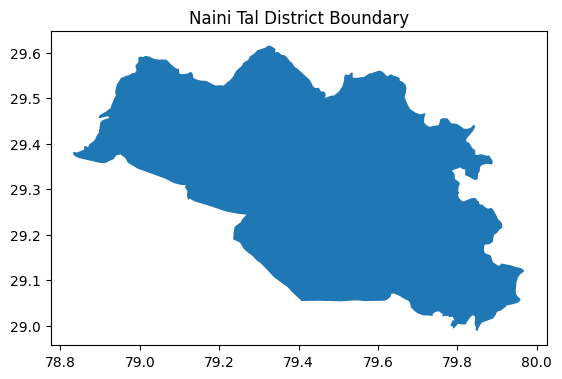

In [12]:
shapefile_name = "IND_adm2.shp"
shapefile_path = f"{VECTOR_PATH}/{shapefile_name}"
try:
    all_districts_gdf = gpd.read_file(shapefile_path)
    district_column_name = 'NAME_2'
    district_to_filter = "Naini Tal"
    nainital_gdf = all_districts_gdf[all_districts_gdf[district_column_name] == district_to_filter]
    if nainital_gdf.empty:
        print(f"ERROR: '{district_to_filter}' not found in column '{district_column_name}'.")
        print("Available districts in your file:", all_districts_gdf[district_column_name].unique())
    else:
        nainital_gdf.plot()
        plt.title("Naini Tal District Boundary")
        plt.show()

except Exception as e:
    print(f"ERROR: Could not load shapefile. Check your 'VECTOR_PATH' and 'shapefile_name'. {e}")

In [16]:
def clip_raster_to_shape(raster_path, shape_gdf, output_path):
    if os.path.exists(output_path):
        return

    try:
        with rasterio.open(raster_path) as src:
            shape_gdf_reprojected = shape_gdf.to_crs(src.crs)
            geometries = shape_gdf_reprojected.geometry.values
            out_image, out_transform = mask(src, geometries, crop=True)
            out_meta = src.meta.copy()

        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })

        with rasterio.open(output_path, "w", **out_meta) as dest:
            dest.write(out_image)

        print(f"saved to: {os.path.basename(output_path)}\n")

    except Exception as e:
        print(f"Error {os.path.basename(raster_path)}: {e}\n")

In [20]:
files_to_clip = {
    PRE_DISASTER_PATH: [
        "LC08_L2SP_145040_20210309_20210317_02_T1_SR_B4.TIF",
        "LC08_L2SP_145040_20210309_20210317_02_T1_SR_B5.TIF",
        "LC08_L2SP_145040_20210309_20210317_02_T1_SR_B7.TIF",
        "LC08_L2SP_145040_20210309_20210317_02_T1_QA_PIXEL.TIF"
    ],
    POST_DISASTER_PATH: [
        "LC08_L2SP_145040_20210410_20210416_02_T1_SR_B4.TIF",
        "LC08_L2SP_145040_20210410_20210416_02_T1_SR_B5.TIF",
        "LC08_L2SP_145040_20210410_20210416_02_T1_SR_B7.TIF",
        "LC08_L2SP_145040_20210410_20210416_02_T1_QA_PIXEL.TIF"
    ],
    DEM_PATH: [
        "DEM.tif"
    ]
}

for folder_path, filenames in files_to_clip.items():
    for filename in filenames:
        raw_path = f"{folder_path}/{filename}"
        output_filename = f"clipped_{filename}"
        output_path = f"{PROCESSED_PATH}/{output_filename}"

        clip_raster_to_shape(
            raster_path=raw_path,
            shape_gdf=nainital_gdf,
            output_path=output_path
        )

saved to: clipped_LC08_L2SP_145040_20210309_20210317_02_T1_SR_B4.TIF

saved to: clipped_LC08_L2SP_145040_20210309_20210317_02_T1_SR_B5.TIF

saved to: clipped_LC08_L2SP_145040_20210309_20210317_02_T1_SR_B7.TIF

saved to: clipped_LC08_L2SP_145040_20210309_20210317_02_T1_QA_PIXEL.TIF

saved to: clipped_LC08_L2SP_145040_20210410_20210416_02_T1_SR_B4.TIF

saved to: clipped_LC08_L2SP_145040_20210410_20210416_02_T1_SR_B5.TIF

saved to: clipped_LC08_L2SP_145040_20210410_20210416_02_T1_SR_B7.TIF

saved to: clipped_LC08_L2SP_145040_20210410_20210416_02_T1_QA_PIXEL.TIF

saved to: clipped_DEM.tif



False Color Composite (B7, B5, B4) for Pre-Fire


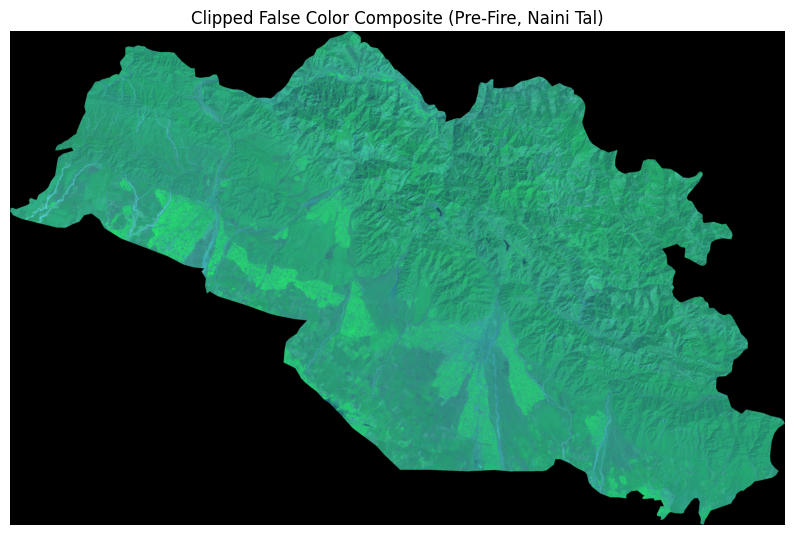

In [24]:
pre_b7_filename = "LC08_L2SP_145040_20210309_20210317_02_T1_SR_B7.TIF"
pre_b5_filename = "LC08_L2SP_145040_20210309_20210317_02_T1_SR_B5.TIF"
pre_b4_filename = "LC08_L2SP_145040_20210309_20210317_02_T1_SR_B4.TIF"
pre_b7_path = f"{PROCESSED_PATH}/clipped_{pre_b7_filename}"
pre_b5_path = f"{PROCESSED_PATH}/clipped_{pre_b5_filename}"
pre_b4_path = f"{PROCESSED_PATH}/clipped_{pre_b4_filename}"

try:
    src_b7 = rasterio.open(pre_b7_path)
    src_b5 = rasterio.open(pre_b5_path)
    src_b4 = rasterio.open(pre_b4_path)

    b7 = src_b7.read(1)
    b5 = src_b5.read(1)
    b4 = src_b4.read(1)

    def normalize(band):
        with np.errstate(divide='ignore', invalid='ignore'):
            band_min, band_max = np.nanmin(band), np.nanmax(band)
            if band_max == band_min:
                return band - band_min
            return (band - band_min) / (band_max - band_min)

    b7_norm = normalize(b7)
    b5_norm = normalize(b5)
    b4_norm = normalize(b4)
    false_color_composite = np.dstack((b7_norm, b5_norm, b4_norm))

    print("False Color Composite (B7, B5, B4) for Pre-Fire")
    plt.figure(figsize=(10,10))
    plt.imshow(false_color_composite)
    plt.title("Clipped False Color Composite (Pre-Fire, Naini Tal)")
    plt.axis('off') # Hide axes
    plt.show()

except Exception as e:
    print(f"ERROR{e}")

False Color Composite (B7, B5, B4) for Post-Fire


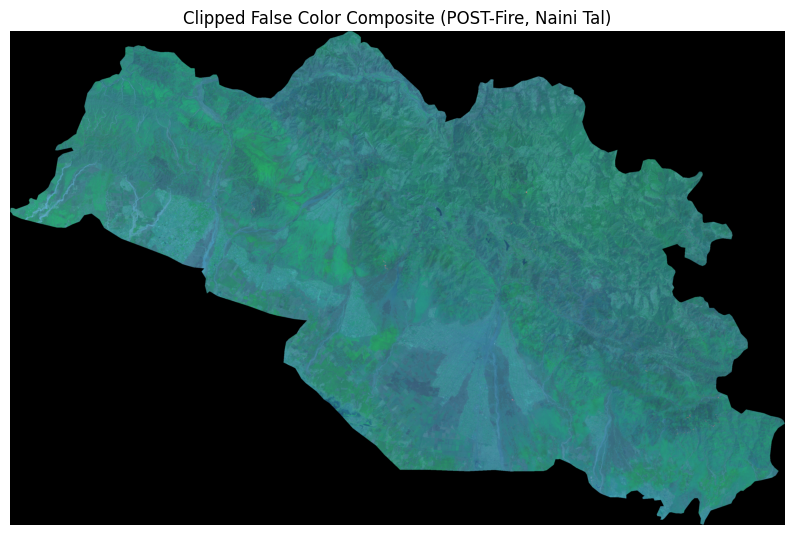

In [25]:
post_b7_filename = "LC08_L2SP_145040_20210410_20210416_02_T1_SR_B7.TIF"
post_b5_filename = "LC08_L2SP_145040_20210410_20210416_02_T1_SR_B5.TIF"
post_b4_filename = "LC08_L2SP_145040_20210410_20210416_02_T1_SR_B4.TIF"
post_b7_path = f"{PROCESSED_PATH}/clipped_{post_b7_filename}"
post_b5_path = f"{PROCESSED_PATH}/clipped_{post_b5_filename}"
post_b4_path = f"{PROCESSED_PATH}/clipped_{post_b4_filename}"

try:
    src_b7 = rasterio.open(post_b7_path)
    src_b5 = rasterio.open(post_b5_path)
    src_b4 = rasterio.open(post_b4_path)

    b7 = src_b7.read(1)
    b5 = src_b5.read(1)
    b4 = src_b4.read(1)

    b7_norm = normalize(b7)
    b5_norm = normalize(b5)
    b4_norm = normalize(b4)

    false_color_composite_post = np.dstack((b7_norm, b5_norm, b4_norm))

    print("False Color Composite (B7, B5, B4) for Post-Fire")
    plt.figure(figsize=(10,10))
    plt.imshow(false_color_composite_post)
    plt.title("Clipped False Color Composite (POST-Fire, Naini Tal)")
    plt.axis('off') # Hide axes
    plt.show()

except Exception as e:
    print(f"ERROR{e}")

In [30]:
CLEAN_PATH = f"{PROCESSED_PATH}/clean"
if not os.path.exists(CLEAN_PATH):
    os.makedirs(CLEAN_PATH)
    print(f"Created folder: {CLEAN_PATH}")
else:
    print(f"Clean data folder already exists: {CLEAN_PATH}")

def apply_cloud_mask(data_raster_path, qa_raster_path, output_path):
    if os.path.exists(output_path):
        print(f"File already exists, skipping: {output_path}")
        return
    try:
        with rasterio.open(qa_raster_path) as qa_src:
            qa_band = qa_src.read(1)
            bad_pixels_mask = (qa_band & 64) != 64
        with rasterio.open(data_raster_path) as data_src:
            data_band = data_src.read(1)
            data_meta = data_src.meta.copy()
            data_band_cleaned = data_band.astype('float32')
            data_band_cleaned[bad_pixels_mask] = np.nan

        data_meta.update({
            'dtype': 'float32',
            'nodata': np.nan
        })

        with rasterio.open(output_path, "w", **data_meta) as dest:
            dest.write(data_band_cleaned, 1) # Write the cleaned band

    except Exception as e:
        print(f"ERROR masking {os.path.basename(data_raster_path)}: {e}\n")

Clean data folder already exists: /content/drive/My Drive/data/processed/clean


In [31]:
pre_b4_filename = "LC08_L2SP_145040_20210309_20210317_02_T1_SR_B4.TIF"
pre_b5_filename = "LC08_L2SP_145040_20210309_20210317_02_T1_SR_B5.TIF"
pre_b7_filename = "LC08_L2SP_145040_20210309_20210317_02_T1_SR_B7.TIF"
pre_qa_filename = "LC08_L2SP_145040_20210309_20210317_02_T1_QA_PIXEL.TIF"


post_b4_filename = "LC08_L2SP_145040_20210410_20210416_02_T1_SR_B4.TIF"
post_b5_filename = "LC08_L2SP_145040_20210410_20210416_02_T1_SR_B5.TIF"
post_b7_filename = "LC08_L2SP_145040_20210410_20210416_02_T1_SR_B7.TIF"
post_qa_filename = "LC08_L2SP_145040_20210410_20210416_02_T1_QA_PIXEL.TIF"

files_to_mask_map = {
    f"clipped_{pre_b4_filename}": f"clipped_{pre_qa_filename}",
    f"clipped_{pre_b5_filename}": f"clipped_{pre_qa_filename}",
    f"clipped_{pre_b7_filename}": f"clipped_{pre_qa_filename}",
    f"clipped_{post_b4_filename}": f"clipped_{post_qa_filename}",
    f"clipped_{post_b5_filename}": f"clipped_{post_qa_filename}",
    f"clipped_{post_b7_filename}": f"clipped_{post_qa_filename}",
}

for data_filename, qa_filename in files_to_mask_map.items():

    data_path = f"{PROCESSED_PATH}/{data_filename}"

    qa_path = f"{PROCESSED_PATH}/{qa_filename}"

    output_path = f"{CLEAN_PATH}/clean_{data_filename}"

    apply_cloud_mask(data_path, qa_path, output_path)

